In [1]:
import os 
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F 
import time 
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

## Load Data

In [3]:
# data augmentation
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2), 
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"
# Use the image_transforms composition here
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [5]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [41]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
# Split dataset
train_size = int(0.75 * len(dataset)) 
val_size = len(dataset) - train_size 
train_size, val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
# Test the loader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
labels[1]

tensor(3)

In [12]:
images[1].shape

torch.Size([3, 224, 224])

In [13]:
images[1].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.169412].


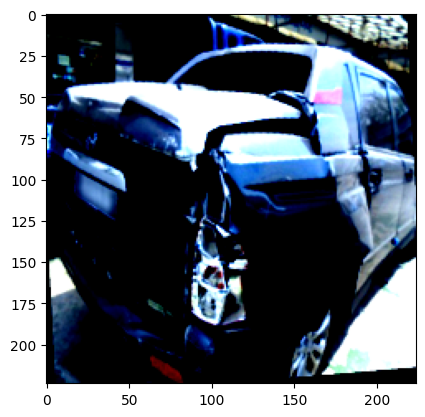

In [14]:
plt.imshow(images[1].permute(1, 2, 0))
plt.show()

## Model 1: CNN

In [15]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),   # (16, 224, 224)
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (32, 112, 112)
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),# (64, 56, 56) 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(), 
            nn.Linear(64*28*28, 512), 
            nn.ReLU(), 
            ## nn.Linear(512, 6)
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x) 
        return x

In [20]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train() 
        running_loss = 0.0 
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device) 

            # Zero the parameter gradients 
            optimizer.zero_grad()
            
            # Forward pass 
            outputs = model(images) 
            loss = criterion(outputs, labels) 
            
            # Backward pass  &  optimization 
            loss.backward() 
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            

    epoch_loss = running_loss / len(train_loader.dataset) 
    print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

    # Validataion 
    model.eval() 
    correct = 0 
    total = 0 
    all_labels = [] 
    all_predictions = [] 

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) 
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())            
        print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [21]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [22]:
all_label, all_predictions = train_model(model, criterion, optimizer, epochs=1) 

Batch: 10, Epoch: 1, Loss: 1.79
Batch: 20, Epoch: 1, Loss: 1.80
Batch: 30, Epoch: 1, Loss: 1.71
Batch: 40, Epoch: 1, Loss: 1.59
Batch: 50, Epoch: 1, Loss: 1.52
Epoch [1/1], Avg Loss: 1.8109
*** Validation Accuracy: 36.87% ***
Execution time: 223.50585842132568 seconds


<pre>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">1</span>, <span class="loss">Loss:</span> <span class="value">1.79</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">1</span>, <span class="loss">Loss:</span> <span class="value">1.90</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">1</span>, <span class="loss">Loss:</span> <span class="value">1.69</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">1</span>, <span class="loss">Loss:</span> <span class="value">1.66</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">1</span>, <span class="loss">Loss:</span> <span class="value">1.72</span>
<span class="epoch-summary">Epoch [<span class="value">1</span>/<span class="value">10</span>], Avg Loss: <span class="value">1.7893</span></span>
<span class="validation">*** Validation Accuracy: 37.57% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">2</span>, <span class="loss">Loss:</span> <span class="value">1.48</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">2</span>, <span class="loss">Loss:</span> <span class="value">1.63</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">2</span>, <span class="loss">Loss:</span> <span class="value">1.43</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">2</span>, <span class="loss">Loss:</span> <span class="value">1.63</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">2</span>, <span class="loss">Loss:</span> <span class="value">1.34</span>
<span class="epoch-summary">Epoch [<span class="value">2</span>/<span class="value">10</span>], Avg Loss: <span class="value">1.4138</span></span>
<span class="validation">*** Validation Accuracy: 45.22% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">3</span>, <span class="loss">Loss:</span> <span class="value">1.36</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">3</span>, <span class="loss">Loss:</span> <span class="value">1.30</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">3</span>, <span class="loss">Loss:</span> <span class="value">1.13</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">3</span>, <span class="loss">Loss:</span> <span class="value">0.88</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">3</span>, <span class="loss">Loss:</span> <span class="value">1.22</span>
<span class="epoch-summary">Epoch [<span class="value">3</span>/<span class="value">10</span>], Avg Loss: <span class="value">1.2531</span></span>
<span class="validation">*** Validation Accuracy: 50.09% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">4</span>, <span class="loss">Loss:</span> <span class="value">1.18</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">4</span>, <span class="loss">Loss:</span> <span class="value">1.04</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">4</span>, <span class="loss">Loss:</span> <span class="value">1.11</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">4</span>, <span class="loss">Loss:</span> <span class="value">1.03</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">4</span>, <span class="loss">Loss:</span> <span class="value">0.88</span>
<span class="epoch-summary">Epoch [<span class="value">4</span>/<span class="value">10</span>], Avg Loss: <span class="value">1.0982</span></span>
<span class="validation">*** Validation Accuracy: 51.30% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">5</span>, <span class="loss">Loss:</span> <span class="value">0.78</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">5</span>, <span class="loss">Loss:</span> <span class="value">0.90</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">5</span>, <span class="loss">Loss:</span> <span class="value">1.08</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">5</span>, <span class="loss">Loss:</span> <span class="value">1.24</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">5</span>, <span class="loss">Loss:</span> <span class="value">0.91</span>
<span class="epoch-summary">Epoch [<span class="value">5</span>/<span class="value">10</span>], Avg Loss: <span class="value">0.9721</span></span>
<span class="validation">*** Validation Accuracy: 54.09% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">6</span>, <span class="loss">Loss:</span> <span class="value">1.06</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">6</span>, <span class="loss">Loss:</span> <span class="value">0.90</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">6</span>, <span class="loss">Loss:</span> <span class="value">0.78</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">6</span>, <span class="loss">Loss:</span> <span class="value">0.99</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">6</span>, <span class="loss">Loss:</span> <span class="value">0.75</span>
<span class="epoch-summary">Epoch [<span class="value">6</span>/<span class="value">10</span>], Avg Loss: <span class="value">0.9053</span></span>
<span class="validation">*** Validation Accuracy: 56.87% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">7</span>, <span class="loss">Loss:</span> <span class="value">0.86</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">7</span>, <span class="loss">Loss:</span> <span class="value">0.80</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">7</span>, <span class="loss">Loss:</span> <span class="value">1.11</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">7</span>, <span class="loss">Loss:</span> <span class="value">1.00</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">7</span>, <span class="loss">Loss:</span> <span class="value">1.11</span>
<span class="epoch-summary">Epoch [<span class="value">7</span>/<span class="value">10</span>], Avg Loss: <span class="value">0.8732</span></span>
<span class="validation">*** Validation Accuracy: 56.87% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">8</span>, <span class="loss">Loss:</span> <span class="value">0.71</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">8</span>, <span class="loss">Loss:</span> <span class="value">0.85</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">8</span>, <span class="loss">Loss:</span> <span class="value">0.83</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">8</span>, <span class="loss">Loss:</span> <span class="value">1.01</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">8</span>, <span class="loss">Loss:</span> <span class="value">1.09</span>
<span class="epoch-summary">Epoch [<span class="value">8</span>/<span class="value">10</span>], Avg Loss: <span class="value">0.8449</span></span>
<span class="validation">*** Validation Accuracy: 55.30% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">9</span>, <span class="loss">Loss:</span> <span class="value">0.77</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">9</span>, <span class="loss">Loss:</span> <span class="value">1.00</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">9</span>, <span class="loss">Loss:</span> <span class="value">0.76</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">9</span>, <span class="loss">Loss:</span> <span class="value">0.68</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">9</span>, <span class="loss">Loss:</span> <span class="value">0.80</span>
<span class="epoch-summary">Epoch [<span class="value">9</span>/<span class="value">10</span>], Avg Loss: <span class="value">0.7649</span></span>
<span class="validation">*** Validation Accuracy: 57.22% ***</span>
<span class="batch">Batch:</span> <span class="value">10</span>, <span class="epoch">Epoch:</span> <span class="value">10</span>, <span class="loss">Loss:</span> <span class="value">0.58</span>
<span class="batch">Batch:</span> <span class="value">20</span>, <span class="epoch">Epoch:</span> <span class="value">10</span>, <span class="loss">Loss:</span> <span class="value">0.59</span>
<span class="batch">Batch:</span> <span class="value">30</span>, <span class="epoch">Epoch:</span> <span class="value">10</span>, <span class="loss">Loss:</span> <span class="value">0.71</span>
<span class="batch">Batch:</span> <span class="value">40</span>, <span class="epoch">Epoch:</span> <span class="value">10</span>, <span class="loss">Loss:</span> <span class="value">0.94</span>
<span class="batch">Batch:</span> <span class="value">50</span>, <span class="epoch">Epoch:</span> <span class="value">10</span>, <span class="loss">Loss:</span> <span class="value">0.71</span>
<span class="epoch-summary">Epoch [<span class="value">10</span>/<span class="value">10</span>], Avg Loss: <span class="value">0.7320</span></span>
<span class="validation">*** Validation Accuracy: 57.74% ***</span>
<span class="execution-time">Execution time: 702.502569437027 seconds</span>
</pre>
</body>
</html>

## Model 2: CNN With Regularization

In [23]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),   # (16, 224, 224)
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (32, 112, 112)
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),# (64, 56, 56) 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(), 
            nn.Linear(64*28*28, 512), 
            nn.ReLU(), 
            nn.Dropout(0.5), 
            ## nn.Linear(512, 6)
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.network(x) 
        return x

In [85]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=1)

Batch: 10, Epoch: 1, Loss: 14.25
Batch: 20, Epoch: 1, Loss: 6.05
Batch: 30, Epoch: 1, Loss: 2.10
Batch: 40, Epoch: 1, Loss: 1.28
Batch: 50, Epoch: 1, Loss: 1.46
Epoch [1/1], Avg Loss: 7.7081
*** Validation Accuracy: 46.43% ***
Execution time: 218.3602957725525 seconds


NameError: name 'all_labels' is not defined

```
Batch: 10, Epoch: 1, Loss: 14.10
Batch: 20, Epoch: 1, Loss: 4.84
Batch: 30, Epoch: 1, Loss: 1.41
Batch: 40, Epoch: 1, Loss: 1.50
Batch: 50, Epoch: 1, Loss: 1.93
Epoch [1/10], Avg Loss: 6.9776
*** Validation Accuracy: 39.48% ***
Batch: 10, Epoch: 2, Loss: 1.52
Batch: 20, Epoch: 2, Loss: 1.41
Batch: 30, Epoch: 2, Loss: 1.25
Batch: 40, Epoch: 2, Loss: 1.68
Batch: 50, Epoch: 2, Loss: 1.70
Epoch [2/10], Avg Loss: 1.4713
*** Validation Accuracy: 46.61% ***
Batch: 10, Epoch: 3, Loss: 1.21
Batch: 20, Epoch: 3, Loss: 1.22
Batch: 30, Epoch: 3, Loss: 1.37
Batch: 40, Epoch: 3, Loss: 1.32
Batch: 50, Epoch: 3, Loss: 1.28
Epoch [3/10], Avg Loss: 1.3041
*** Validation Accuracy: 50.09% ***
Batch: 10, Epoch: 4, Loss: 0.99
Batch: 20, Epoch: 4, Loss: 1.27
Batch: 30, Epoch: 4, Loss: 1.35
Batch: 40, Epoch: 4, Loss: 1.28
Batch: 50, Epoch: 4, Loss: 1.12
Epoch [4/10], Avg Loss: 1.2812
*** Validation Accuracy: 48.00% ***
Batch: 10, Epoch: 5, Loss: 1.16
Batch: 20, Epoch: 5, Loss: 1.24
Batch: 30, Epoch: 5, Loss: 1.10
Batch: 40, Epoch: 5, Loss: 1.11
Batch: 50, Epoch: 5, Loss: 1.77
Epoch [5/10], Avg Loss: 1.2080
*** Validation Accuracy: 53.39% ***
Batch: 10, Epoch: 6, Loss: 1.12
Batch: 20, Epoch: 6, Loss: 1.10
Batch: 30, Epoch: 6, Loss: 1.12
Batch: 40, Epoch: 6, Loss: 1.09
Batch: 50, Epoch: 6, Loss: 0.90
Epoch [6/10], Avg Loss: 1.1537
*** Validation Accuracy: 51.83% ***
Batch: 10, Epoch: 7, Loss: 1.30
Batch: 20, Epoch: 7, Loss: 1.12
Batch: 30, Epoch: 7, Loss: 1.02
Batch: 40, Epoch: 7, Loss: 1.02
Batch: 50, Epoch: 7, Loss: 1.22
Epoch [7/10], Avg Loss: 1.1284
*** Validation Accuracy: 54.26% ***
Batch: 10, Epoch: 8, Loss: 0.95
Batch: 20, Epoch: 8, Loss: 1.21
Batch: 30, Epoch: 8, Loss: 1.12
Batch: 40, Epoch: 8, Loss: 1.16
Batch: 50, Epoch: 8, Loss: 0.92
Epoch [8/10], Avg Loss: 1.1307
*** Validation Accuracy: 52.52% ***
Batch: 10, Epoch: 9, Loss: 0.98
Batch: 20, Epoch: 9, Loss: 1.11
Batch: 30, Epoch: 9, Loss: 1.07
Batch: 40, Epoch: 9, Loss: 0.95
Batch: 50, Epoch: 9, Loss: 0.90
Epoch [9/10], Avg Loss: 1.0807
*** Validation Accuracy: 53.04% ***
Batch: 10, Epoch: 10, Loss: 1.00
Batch: 20, Epoch: 10, Loss: 1.09
Batch: 30, Epoch: 10, Loss: 1.36
Batch: 40, Epoch: 10, Loss: 0.96
Batch: 50, Epoch: 10, Loss: 1.07
Epoch [10/10], Avg Loss: 1.0907
*** Validation Accuracy: 50.43% ***
Execution time: 667.3993468284607 seconds
```

## Model 3: Transfer Learning With Efficient Net

In [26]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\adian/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%


1280

In [27]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for params in self.model.parameters():
            params.requires_grad = False 

        in_features = self.model.classifier[1].in_features
        # Replace the final fully connected layer
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x) 
        return x

In [28]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=1)

Batch: 10, Epoch: 1, Loss: 1.63
Batch: 20, Epoch: 1, Loss: 1.60
Batch: 30, Epoch: 1, Loss: 1.44
Batch: 40, Epoch: 1, Loss: 1.24
Batch: 50, Epoch: 1, Loss: 1.18
Epoch [1/1], Avg Loss: 1.4751
*** Validation Accuracy: 56.00% ***
Execution time: 225.94108819961548 seconds


```
Batch: 10, Epoch: 1, Loss: 1.69
Batch: 20, Epoch: 1, Loss: 1.55
Batch: 30, Epoch: 1, Loss: 1.37
Batch: 40, Epoch: 1, Loss: 1.30
Batch: 50, Epoch: 1, Loss: 1.23
Epoch [1/10], Avg Loss: 1.5016 ***
*** Validation Accuracy: 52.70% ***
Batch: 10, Epoch: 2, Loss: 1.26
Batch: 20, Epoch: 2, Loss: 1.08
Batch: 30, Epoch: 2, Loss: 1.11
Batch: 40, Epoch: 2, Loss: 1.06
Batch: 50, Epoch: 2, Loss: 1.06
Epoch [2/10], Avg Loss: 1.1384 ***
*** Validation Accuracy: 60.52% ***
Batch: 10, Epoch: 3, Loss: 0.96
Batch: 20, Epoch: 3, Loss: 1.01
Batch: 30, Epoch: 3, Loss: 0.94
Batch: 40, Epoch: 3, Loss: 1.13
Batch: 50, Epoch: 3, Loss: 1.13
Epoch [3/10], Avg Loss: 1.0007 ***
*** Validation Accuracy: 62.63% ***
Batch: 10, Epoch: 4, Loss: 1.12
Batch: 20, Epoch: 4, Loss: 0.88
Batch: 30, Epoch: 4, Loss: 1.09
Batch: 40, Epoch: 4, Loss: 1.12
Batch: 50, Epoch: 4, Loss: 1.12
Epoch [4/10], Avg Loss: 0.9877 ***
*** Validation Accuracy: 63.65% ***
Batch: 10, Epoch: 5, Loss: 0.90
Batch: 20, Epoch: 5, Loss: 0.84
Batch: 30, Epoch: 5, Loss: 0.82
Batch: 40, Epoch: 5, Loss: 0.92
Batch: 50, Epoch: 5, Loss: 0.99
Epoch [5/10], Avg Loss: 0.8969 ***
*** Validation Accuracy: 66.78% ***
Batch: 10, Epoch: 6, Loss: 0.77
Batch: 20, Epoch: 6, Loss: 0.84
Batch: 30, Epoch: 6, Loss: 0.62
Batch: 40, Epoch: 6, Loss: 0.83
Batch: 50, Epoch: 6, Loss: 0.60
Epoch [6/10], Avg Loss: 0.8590 ***
*** Validation Accuracy: 64.27% ***
Batch: 10, Epoch: 7, Loss: 0.90
Batch: 20, Epoch: 7, Loss: 0.81
Batch: 30, Epoch: 7, Loss: 0.68
Batch: 40, Epoch: 7, Loss: 0.87
Batch: 50, Epoch: 7, Loss: 0.96
Epoch [7/10], Avg Loss: 0.8390 ***
*** Validation Accuracy: 65.96% ***
Batch: 10, Epoch: 8, Loss: 0.76
Batch: 20, Epoch: 8, Loss: 0.84
Batch: 30, Epoch: 8, Loss: 0.76
Batch: 40, Epoch: 8, Loss: 0.76
Batch: 50, Epoch: 8, Loss: 0.86
Epoch [8/10], Avg Loss: 0.8166 ***
*** Validation Accuracy: 64.35% ***
Batch: 10, Epoch: 9, Loss: 0.88
Batch: 20, Epoch: 9, Loss: 0.82
Batch: 30, Epoch: 9, Loss: 0.76
Batch: 40, Epoch: 9, Loss: 0.99
Batch: 50, Epoch: 9, Loss: 0.78
Epoch [9/10], Avg Loss: 0.8244 ***
*** Validation Accuracy: 65.39% ***
Batch: 10, Epoch: 10, Loss: 0.69
Batch: 20, Epoch: 10, Loss: 0.77
Batch: 30, Epoch: 10, Loss: 0.61
Batch: 40, Epoch: 10, Loss: 0.81
Batch: 50, Epoch: 10, Loss: 0.87
Epoch [10/10], Avg Loss: 0.7540 ***
*** Validation Accuracy: 65.74% ***
Execution time: 777.6241436004639 seconds
```

## Model 4: Transfer Learning With ResNet

In [31]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5): 
        super().__init__() 
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for params in self.model.parameters():
           params.requires_grad = False 
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate), 
            nn.Linear(self.model.fc.in_features, num_classes)
        )
    def forward(self, x):
        x = self.model(x) 
        return x

In [34]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.00
Batch: 20, Epoch: 1, Loss: 0.94
Batch: 30, Epoch: 1, Loss: 0.77
Batch: 40, Epoch: 1, Loss: 1.00
Batch: 50, Epoch: 1, Loss: 0.70
Batch: 10, Epoch: 2, Loss: 0.76
Batch: 20, Epoch: 2, Loss: 0.45
Batch: 30, Epoch: 2, Loss: 0.59
Batch: 40, Epoch: 2, Loss: 0.41
Batch: 50, Epoch: 2, Loss: 0.59
Batch: 10, Epoch: 3, Loss: 0.24
Batch: 20, Epoch: 3, Loss: 0.44
Batch: 30, Epoch: 3, Loss: 0.36
Batch: 40, Epoch: 3, Loss: 0.45
Batch: 50, Epoch: 3, Loss: 0.36
Batch: 10, Epoch: 4, Loss: 0.18
Batch: 20, Epoch: 4, Loss: 0.43
Batch: 30, Epoch: 4, Loss: 0.19
Batch: 40, Epoch: 4, Loss: 0.16
Batch: 50, Epoch: 4, Loss: 0.22
Batch: 10, Epoch: 5, Loss: 0.23
Batch: 20, Epoch: 5, Loss: 0.14
Batch: 30, Epoch: 5, Loss: 0.30
Batch: 40, Epoch: 5, Loss: 0.07
Batch: 50, Epoch: 5, Loss: 0.46
Batch: 10, Epoch: 6, Loss: 0.12
Batch: 20, Epoch: 6, Loss: 0.07
Batch: 30, Epoch: 6, Loss: 0.20
Batch: 40, Epoch: 6, Loss: 0.10
Batch: 50, Epoch: 6, Loss: 0.11
Batch: 10, Epoch: 7, Loss: 0.10
Batch: 2

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [35]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.86
Batch: 20, Epoch: 1, Loss: 0.66
Batch: 30, Epoch: 1, Loss: 0.65
Batch: 40, Epoch: 1, Loss: 0.72
Batch: 50, Epoch: 1, Loss: 1.13
Batch: 10, Epoch: 2, Loss: 0.63
Batch: 20, Epoch: 2, Loss: 0.69
Batch: 30, Epoch: 2, Loss: 0.57
Batch: 40, Epoch: 2, Loss: 0.67
Batch: 50, Epoch: 2, Loss: 0.44
Batch: 10, Epoch: 3, Loss: 0.40
Batch: 20, Epoch: 3, Loss: 0.26
Batch: 30, Epoch: 3, Loss: 0.17
Batch: 40, Epoch: 3, Loss: 0.41
Batch: 50, Epoch: 3, Loss: 0.37
Batch: 10, Epoch: 4, Loss: 0.24
Batch: 20, Epoch: 4, Loss: 0.22
Batch: 30, Epoch: 4, Loss: 0.24
Batch: 40, Epoch: 4, Loss: 0.47
Batch: 50, Epoch: 4, Loss: 0.41
Batch: 10, Epoch: 5, Loss: 0.29
Batch: 20, Epoch: 5, Loss: 0.19
Batch: 30, Epoch: 5, Loss: 0.24
Batch: 40, Epoch: 5, Loss: 0.43
Batch: 50, Epoch: 5, Loss: 0.16
Batch: 10, Epoch: 6, Loss: 0.20
Batch: 20, Epoch: 6, Loss: 0.07
Batch: 30, Epoch: 6, Loss: 0.35
Batch: 40, Epoch: 6, Loss: 0.20
Batch: 50, Epoch: 6, Loss: 0.08
Batch: 10, Epoch: 7, Loss: 0.25
Batch: 2

## Model Evaluation Using Classification Report & Confusion Matrix

In [37]:
labels[:5], predictions[:5]

([np.int64(5), np.int64(5), np.int64(2), np.int64(4), np.int64(4)],
 [np.int64(4), np.int64(5), np.int64(2), np.int64(4), np.int64(5)])

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       123
           1       0.75      0.72      0.74        83
           2       0.90      0.92      0.91       129
           3       0.85      0.73      0.79        73
           4       0.69      0.57      0.62        79
           5       0.72      0.91      0.80        88

    accuracy                           0.80       575
   macro avg       0.79      0.78      0.78       575
weighted avg       0.80      0.80      0.80       575



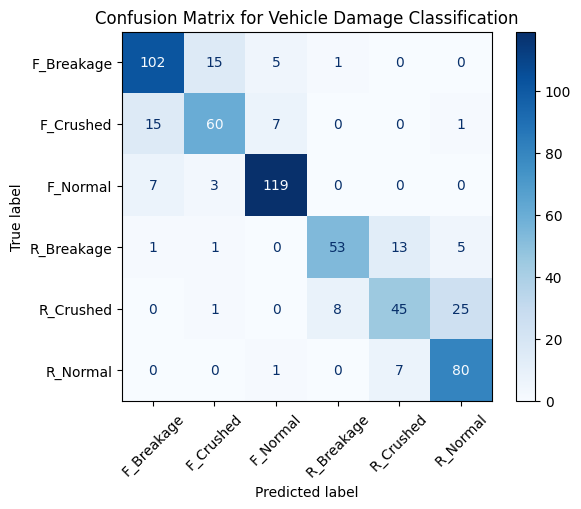

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [43]:
torch.save(model.state_dict(), 'saved_model.pth')